# Politics in Julliard

In [1]:
SCHOOL="julliard"
SUBJECT="opinion"
START_YEAR=2010
FINAL_YEAR=2022
DATA_DIR="data"      # should be 'data'
OUTPUT_DIR="output"  # should be 'output'

In [2]:
%pwd

'/home/harry/Coding/ASDRP/diversity-colleges/notebooks'

In [3]:
%cd ..

/home/harry/Coding/ASDRP/diversity-colleges


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/harry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import sys
sys.path.append('src')
import ouraws
import ourgraphs
import textutil

In [6]:
# NOTE: before loading, we need to be in the "diversity-colleges" folder

S3OBJECT_KEY = f"{DATA_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [39]:
df.shape

(979, 6)

In [40]:
df.head(2)

,title,url,body,year,month,day
0,Creative Associate Rhiannon Giddens in Residence,https://www.juilliard.edu/news/161936/creative...,"This winter, musician, composer, and Creative ...",2023,3,9
1,Alumni Giving Day Match,https://www.juilliard.edu/news/161921/alumni-g...,Did you know that 25 percent of all donations ...,2023,3,8


In [7]:
import requests
import os

BIPARTISAN_API_KEY = os.getenv("BIPARTISAN_API")
# print(BIPARTISAN_API_KEY)
BIPARTISAN_URL = "https://api.thebipartisanpress.com/api/endpoints/beta/robert"

None


In [8]:
df2022 = df[df['year'] == 2022]

articles_list = df2022['body'].to_list()
for article in articles_list:
    payload = {"API": BIPARTISAN_API_KEY, "Text": article.encode("utf-8")}
    response = requests.post(BIPARTISAN_URL, data=payload)
    print(response.text)
    break

1.484896


In [27]:
df['year'].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014])

In [31]:
# SYNCHRONOUS METHOD : TAKES A LONG TIME

results = []

for year in range(2014, 2023):
    df2 = df[df['year'] == year]
    print(f"Year: {year} ... {df2.shape[0]}")

    articles_list = df2['body'].to_list()
    value_sum = 0.0
    article_count = 0
    for article in articles_list:
        payload = {"API": BIPARTISAN_API_KEY, "Text": article.encode("utf-8")}
        response = requests.post(BIPARTISAN_URL, data=payload)
        try:
            print(response.text)
            value_sum += float(response.text)
            article_count += 1
#             print(f"{article_count}", end=".")
        except:
            pass  # this is a non-number
        
    results.append({
        'year' : year,
        'article_count' : article_count,
        'polarity_sum' : value_sum,
        'polarity_avg' : float(value_sum) / article_count
    })

    print(f"{year}\t{article_count}\t{value_sum}\t{value_sum/article_count}")
# for each year, get all articles' bodies & send to bipartisan press API 
#    and sum up the values & output the average for each year

Year: 2014 ... 2
400 Bad Request: The browser (or proxy) sent a request that this server could not understand.
400 Bad Request: The browser (or proxy) sent a request that this server could not understand.


ZeroDivisionError: float division by zero

In [14]:
import pandas as pd

RESULTS_FILE = f"{DATA_DIR}/{SCHOOL}-POLARITY.parquet"

results_df = pd.DataFrame.from_records(results)
results_df.to_parquet(RESULTS_FILE)

In [12]:
# ASYNCHRONOUS METHOD : should be a lot faster
import asyncio

results = []

for year in range(2014, 2023):
    df2 = df[df['year'] == year]
    print(f"Year: {year} ... {df2.shape[0]}")

    articles_list = df2['body'].to_list()
    value_sum = 0.0
    article_count = 0
    for article in articles_list:
        payload = {"API": "gAAAAABeVpQJKRM5BqPX91XW2AKfz8pJosk182maAweJcm5ORAkkBFj__d2feG4H5KIeOKFyhUVSY_uGImiaSBCwy2L6nWxx4g==", "Text": article.encode("utf-8")}
        response = requests.post(BIPARTISAN_URL, data=payload)
        try:
            value_sum += float(response.text)
            article_count += 1
            # print(f"{article_count}", end=".")
        except:
            pass  # this is a non-number
        
    results.append({
        'year' : year,
        'article_count' : article_count,
        'polarity_sum' : value_sum,
        'polarity_avg' : float(value_sum) / article_count
    })

    print(f"{year}\t{article_count}\t{value_sum}\t{value_sum/article_count}")
# for each year, get all articles' bodies & send to bipartisan press API 
#    and sum up the values & output the average for each year

Year: 2014 ... 2
2014	2	-6.231741	-3.1158705
Year: 2015 ... 5
2015	5	-3.266332	-0.6532663999999999
Year: 2016 ... 5
2016	5	4.508292999999999	0.9016585999999999
Year: 2017 ... 149
2017	149	-227.09316499999997	-1.5241152013422816
Year: 2018 ... 222
2018	222	-317.17682500000006	-1.4287244369369372
Year: 2019 ... 195
2019	195	-305.0255999999999	-1.5642338461538456
Year: 2020 ... 135
2020	135	-367.17617600000005	-2.7198235259259262
Year: 2021 ... 127
2021	127	-283.5700260000001	-2.2328348503937017
Year: 2022 ... 119
2022	118	-209.25398999999996	-1.7733388983050844


## Bipartisan Results Analysis

In [15]:
S3_POLITICS_KEY = f"{DATA_DIR}/{SCHOOL}-POLARITY.parquet"

def getStoredResults():
    return ouraws.getFromS3(S3_POLITICS_KEY)

print(f"reading from {S3_POLITICS_KEY}")
results_df = getStoredResults()

print(f"Number of records: {results_df.shape}")
print(results_df.sort_values(by='year', ascending=True))

reading from data/julliard-POLARITY.parquet
	getFromS3(): did not find object: data/julliard-POLARITY.parquet


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['polarity_avg']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="polarity_avg", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label=f"slope: {slope:.2f}")

plt.title("Julliard: Bipartisan polarity by year")
plt.legend(loc='upper right')
# plt.ylim(min(y)*0.95, max(y)*1.05)
plt.ylim(min(y)*0.95, 0)
plt.show()

In [82]:
import pandas as pd
total_results_df = pd.read_csv("data/bipartisan-results-20220221.csv", index_col=0, header=None)

In [83]:
total_results_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,,,,,,,,,,,,,
year,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000
harvard,-1.057473,-2.333275,-3.726742,-1.840690,-2.869477,-2.917216,-3.820909,-4.129395,-4.107001,-3.666681,-5.433845,-4.200837,NaN
brown,-2.991370,-3.671349,-3.350092,-4.084351,-4.615611,-5.190118,-6.026916,-8.408848,-7.753286,-7.035055,-7.238564,-7.926209,-6.898120
middlebury,-1.279805,-1.319872,-3.770691,-4.083850,-2.986582,-3.047329,-7.126556,-6.576873,-5.891277,-4.972410,-7.725298,-6.959314,-6.677171


In [84]:
total_results_df = total_results_df.T
total_results_df.head(2)

,year,harvard,brown,middlebury
1,2010.0,-1.057473,-2.991370,-1.279805
2,2011.0,-2.333275,-3.671349,-1.319872


In [85]:
total_results_df['year'] = total_results_df['year'].astype(int)
total_results_df.head(2)

,year,harvard,brown,middlebury
1,2010,-1.057473,-2.991370,-1.279805
2,2011,-2.333275,-3.671349,-1.319872


In [86]:
total_results_df.columns

Index(['year', 'harvard', 'brown', 'middlebury'], dtype='object', name=0)

In [87]:
total_results_df['brown']

1    -2.991370
2    -3.671349
3    -3.350092
4    -4.084351
5    -4.615611
6    -5.190118
7    -6.026916
8    -8.408848
9    -7.753286
10   -7.035055
11   -7.238564
12   -7.926209
13   -6.898120
Name: brown, dtype: float64

## Brown

In [88]:
x = total_results_df['year']
y = total_results_df['brown']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

/Users/theodoremui/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


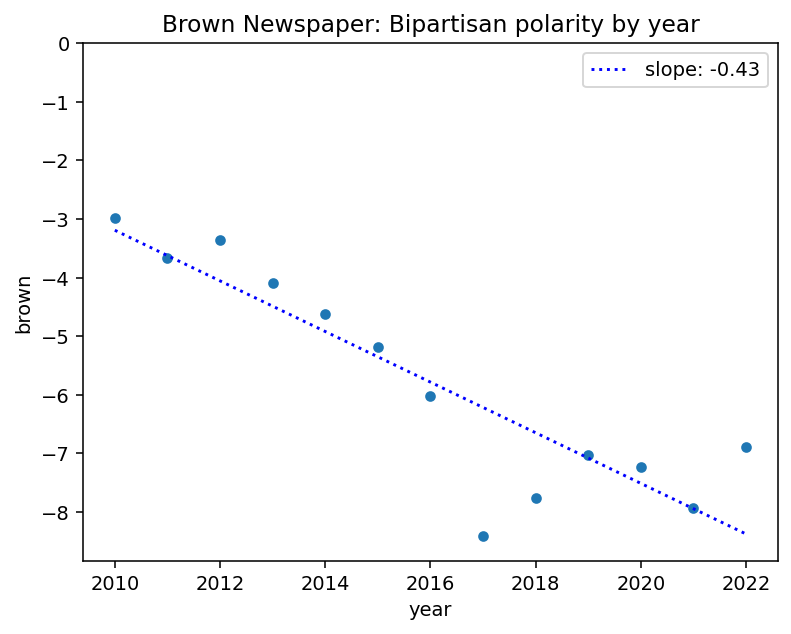

In [89]:
# Create a line plot of the data
total_results_df.plot(x='year', y='brown', kind='scatter')
# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label=f"slope: {slope:.2f}")

plt.title("Brown Newspaper: Bipartisan polarity by year")
plt.legend(loc='upper right')
# plt.ylim(min(y)*0.95, max(y)*1.05)
plt.ylim(min(y)*1.05, 0)
plt.show()

## Middlebury

In [75]:
x = total_results_df['year']
y = total_results_df['middlebury']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

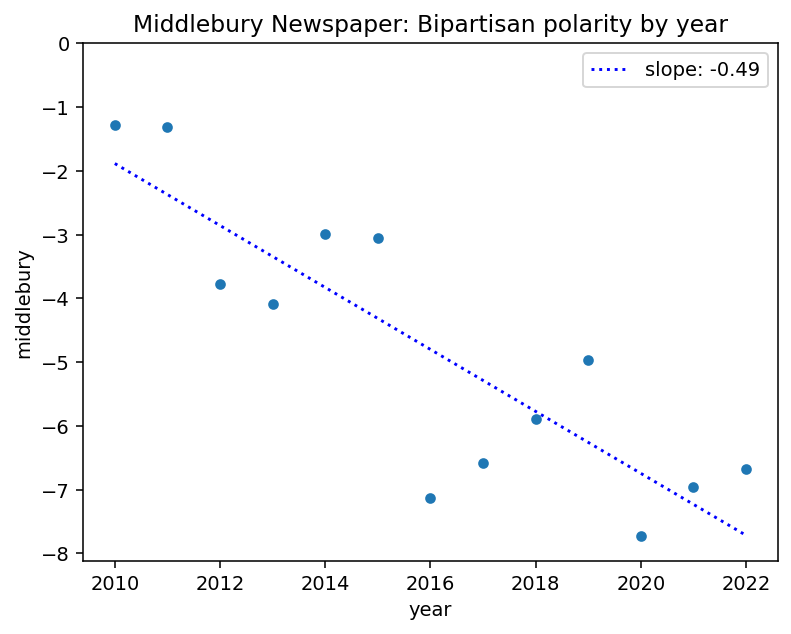

In [78]:
# Create a line plot of the data
total_results_df.plot(x='year', y='middlebury', kind='scatter')
# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label=f"slope: {slope:.2f}")

plt.title("Middlebury Newspaper: Bipartisan polarity by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*1.05, 0)
plt.show()